# Cat Face GAN model  

This is a project to test some of the concepts I have learnt for a Generative Adversial Network (GAN) and also to practise using Git. 

## Step 1: Dataset Inspection 

Since the dataset I've obtained from https://github.com/Ferlix/Cat-faces-dataset should already be standardised to 29,842 64x64 RRB images of cats' faces, there shouldn't be a need to normalise them any further. However, it is still good practice to just take a look at the the pics just to make sure. 

In [1]:
import os 
from matplotlib.image import imread
import numpy as np

In [2]:
%cd "D:/data_science/kaggle/CatFaceGAN"
%pwd

D:\data_science\kaggle\CatFaceGAN


'D:\\data_science\\kaggle\\CatFaceGAN'

In [3]:
imgpath=r'dataset'

In [4]:
dimension1 = []
dimension2 = []
colours = []
for filename in os.listdir(imgpath):
    img = imread(imgpath + '\\' + filename)
    d1,d2,colour = img.shape
    dimension1.append(d1)
    dimension2.append(d2)
    colours.append(colour)

In [5]:
print (np.min(dimension1))
print (np.max(dimension1))
print (np.min(dimension2))
print (np.max(dimension2))
print (np.min(colours))
print (np.max(colours))
print(len(dimension1))

64
64
64
64
3
3
29843


As shown above, it is safe to assume that all 29,843 images are 64x64 and are RGB mode. 

## Step 2: creating GAN model

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Dropout, LeakyReLU

In [7]:
coding_size = 100 
#coding size will be the start of the generator shape 
#it should be smaller than the size of the final image (64x64) but not too small

In [21]:
#generator is a model that takes in noise and creates images 
#these images will try to bypass the classifier (discriminator) and get fake images 
generator = Sequential() 
generator.add(Dense(8*8*128, input_shape=[coding_size]))
generator.add(Reshape([8, 8, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, 
                              padding="same", activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, 
                              padding="same", activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, 
                              padding="same", activation="tanh"))

In [22]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 64)        204864    
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 32, 32, 64)        102464    
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)       

In [23]:
#discriminator is a classification model, employing typical CNN techniques 
discriminator = Sequential() 
discriminator.add(Conv2D(64, kernel_size=5, strides=1, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[64, 64, 3]))
discriminator.add(MaxPooling2D(2,2))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(64, kernel_size=5, strides=1, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(MaxPooling2D(2,2))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(64, activation='relu'))
discriminator.add(Dense(64, activation='relu'))
discriminator.add(Dense(1, activation="sigmoid"))

In [24]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)         

In [25]:
GAN=Sequential([generator,discriminator])

In [26]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [27]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

## Step 3: loading the images into train data 

In [28]:
training_data = []

for filename in os.listdir(imgpath):
    img = imread(imgpath + '\\' + filename)
    training_data.append(img)

In [29]:
X_train = np.array(training_data).reshape(-1,64,64,3) * 2. - 1.

In [30]:
X_train.shape

(29843, 64, 64, 3)

In [31]:
print(X_train.min())
print(X_train.max())

-1.0
1.0


## Step 4: training GAN model 

In [33]:
batch_size = 32
my_data = X_train

dataset= tf.data.Dataset.from_tensor_slices(my_data)
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size,drop_remainder=True)
epochs = 20

generator, discriminator = GAN.layers
for epoch in range(epochs):
      print(f"Currently on Epoch {epoch+1}")
      i = 0
      for X_batch in dataset:
          i = i+1
          if i%100 ==0:
            print(f"\t Currently on batch number {i} of {len(my_data)//batch_size}")
          # Discriminator 
          noise = tf.random.normal(shape=[batch_size,coding_size])
          gen_images = generator(noise)
          X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch, tf.float32)], axis=0)
          y1 = tf.constant([[0.]]*batch_size+ [[1.]]* batch_size) #0 for the fake images and 1 for real]]
          discriminator.trainable = True
          discriminator.train_on_batch(X_fake_vs_real, y1)

          # Generator
          noise = tf.random.normal(shape=[batch_size, coding_size])
          y2 = tf.constant([[1.]]*batch_size)
          discriminator.trainable = False 
          GAN.train_on_batch(noise,y2)
printt("Training Completed.")

Currently on Epoch 1
	 Currently on batch number 100 of 932
	 Currently on batch number 200 of 932
	 Currently on batch number 300 of 932
	 Currently on batch number 400 of 932
	 Currently on batch number 500 of 932
	 Currently on batch number 600 of 932
	 Currently on batch number 700 of 932
	 Currently on batch number 800 of 932
	 Currently on batch number 900 of 932
Currently on Epoch 2
	 Currently on batch number 100 of 932
	 Currently on batch number 200 of 932
	 Currently on batch number 300 of 932
	 Currently on batch number 400 of 932
	 Currently on batch number 500 of 932
	 Currently on batch number 600 of 932
	 Currently on batch number 700 of 932
	 Currently on batch number 800 of 932
	 Currently on batch number 900 of 932
Currently on Epoch 3
	 Currently on batch number 100 of 932
	 Currently on batch number 200 of 932
	 Currently on batch number 300 of 932
	 Currently on batch number 400 of 932
	 Currently on batch number 500 of 932
	 Currently on batch number 600 of 932
	

In [34]:
noise = tf.random.normal(shape=[10, coding_size])

In [35]:
noise.shape

TensorShape([10, 100])

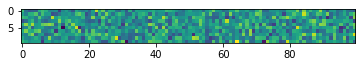

In [36]:
import matplotlib.pyplot as plt
plt.imshow(noise)

In [37]:
images = generator(noise)

In [38]:
single_image = images[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


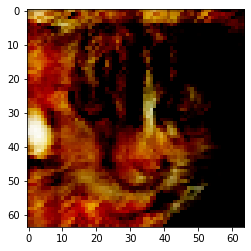

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


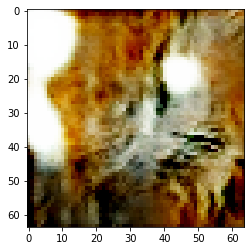

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


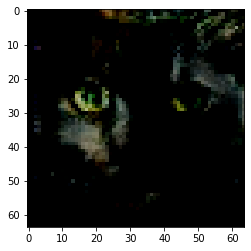

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


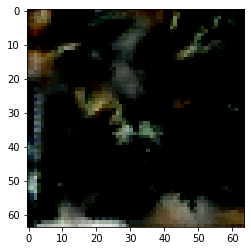

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


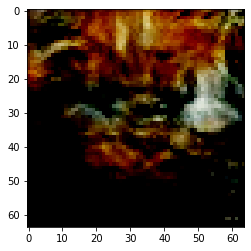

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


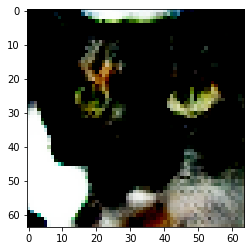

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


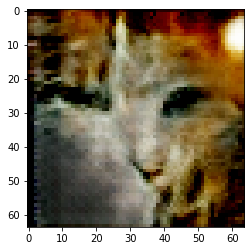

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


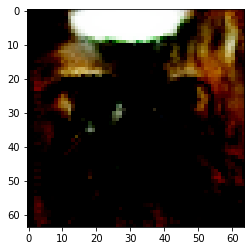

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


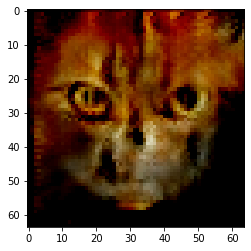

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


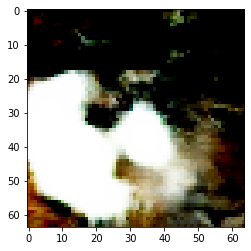

In [41]:
for image in images:
    plt.imshow(image.numpy().reshape(64,64,3))
    plt.show()